[![Open In Colab](./colab-badge.png)](https://colab.research.google.com/github/subhacom/moose-notebooks/blob/main/Stochastic_chemical_model.ipynb) [![Binder](./binder_logo.png)](https://mybinder.org/v2/gh/MooseNeuro/moose-notebooks/HEAD?labpath=Stochastic_chemical_model.ipynb)

In [1]:
## Only required on colab! Uncomment to enable.
# !pip install pymoose --quiet

# Randomness in chemistry

*Note: This is based on the simple bistables example by Upi Bhalla, available as a script in moose-examples/tutorials/ChemicalBistables/simpleBis.py.*

The chemical kinetics model with enzymatic reactions presents a case of averages. We tend to forget that chemical reactions are actually about forming or breaking bonds between particles like ions and molecules. Usual kinetic laws like the law of mass action or the Michaelis-Menten formulation represent an approximation over a large number of such particles.

We probably learnt in high-school physics that the pressure of a gas is the result of lots of gas molecules bumping against the wall of the container, and its temperature is related to the kinetic energy of the molecules. In a solution also, the ions or molecules bounce around under thermal motion. Unless there is specific molecular machinery providing directed force, they move under Brownian motion. When by chance, two reactant particles hit one another, they may undergo chemical interaction. Thus, at the scale of a small number of particles, chemical reactions are discrete random events, rather than the continuous changes we see in a beaker in the chemistry lab.

In the biological cell, and especially in small compartmentalized volumes like the neuronal spine, the number of reacting molecules, ions, etc., can be so small that the randomness of the chemical interaction can render the macroscopic chemical laws inaccurate. Another word for this randomness is *stochasticity* and such random processes are called *stochastic process*.

## Exercise

Assuming a $Ca^{2+}$ concentration of $1\mu M$, what would be the number of $Ca^{2+}$ ions in a neuronal spine of volume $1\mu m^{3}$?

## Bistability in a stochastic system

In the simple bistable model, we used enzyme kinetics following a macroscopic rules. Because of the small volumes and numbers in neuronal compartments, biochemical pathways in neurons may have stochasticity. MOOSE allows you to implement such systems simply by changing the chemical kinetics solver.

Let us revisit the bistable chemical reaction we implemented before:

$A \xrightleftharpoons[C]{B} B$

The steps below are identical to that notebook, except we setup a stochastic solver for the stoichiometry.


In [2]:
# Usual imports
import numpy as np
import matplotlib.pyplot as plt

import moose

## Create containers for model and data

In [3]:
# Containers - we create 'model' and 'data' containers inside /container, 
# deleting it first if it already exists. Otherwise existing objects will
# be reused in the simulation, leading to errors

cpath = '/container'

if moose.exists(cpath):
    moose.delete(cpath)
moose.Neutral(cpath)
    
model = moose.Neutral(f'{cpath}/model')
data = moose.Neutral(f'{cpath}/data')




## Setup chemical compartment for the reaction

In [4]:
# Setup chemical compartment for the reaction

comp = moose.CubeMesh(f'{model.path}/comp')   # Chemical compartment
comp.volume = 1e-21 # m^3

# Get a handle to the mesh created automatically by the compartment
mesh = moose.element(f'{comp.path}/mesh' ) 

## Create molecules and reactions

In [5]:
# Create molecules and reactions

# Pools are the molecule-pools for substrates, products, and enzymes
a = moose.Pool(f'{comp.path}/a')
b = moose.Pool(f'{comp.path}/b')
c = moose.Pool(f'{comp.path}/c')

# Create the enzymatic reaction objects
enz1 = moose.Enz(f'{comp.path}/b/enz1')
enz2 = moose.Enz(f'{comp.path}/c/enz2')

# Create molecule pools representing enzyme-substrate complex
cplx1 = moose.Pool(f'{comp.path}/b/enz1/cplx')
cplx2 = moose.Pool(f'{comp.path}/c/enz2/cplx')

## Connect up the the molecules and enzymes and the reaction object

In [6]:
# Connect them up for reactions ...

# Connect enzymatic reaction enz1 to its molecule pools
moose.connect(enz1, 'sub', a, 'reac')  # a is the substrate molecule pool for enz1 (b)
moose.connect(enz1, 'prd', b, 'reac')  # b is the product molecule pool for enz1 
moose.connect(enz1, 'enz', b, 'reac')  # b is also the enzyme molecule pool for enz1
moose.connect(enz1, 'cplx', cplx1, 'reac')   # cplx1 is the enzyme-substrate complex pool for enz1

# Connect enzymatic reaction enz2 to its molecule pools
moose.connect(enz2, 'sub', b, 'reac')   # b is the substrate molecule pool for enz2 (c)
moose.connect(enz2, 'prd', a, 'reac')   # a is the product molecule pool for enz2 
moose.connect(enz2, 'enz', c, 'reac')   # c is the enzyme molecule pool for enz2
moose.connect(enz2, 'cplx', cplx2, 'reac')  # cplx2 is the enzyme-substrate complex pool for enz2

<moose.SingleMsg id=5 dataIndex=7 path=/Msgs[0]/singleMsg[7]>

# Set up tables to accummulate simulated concentrations

In [7]:
# Create the output tables
outputA = moose.Table2(f'/{data.path}/concA')
outputB = moose.Table2(f'{data.path}/concB')

# connect up the tables
moose.connect(outputA, 'requestOut', a, 'getConc')
moose.connect(outputB, 'requestOut', b, 'getConc')

<moose.SingleMsg id=5 dataIndex=9 path=/Msgs[0]/singleMsg[9]>

Up to this point was just setting up the model structure. This part should be run only once. If you want to modify the structure, then start from top where we delete the container first, so that you have a clean slate. Otherwise each rerun of `moose.connect()` with the same two objects will keep adding more connections, essentially changing the order of the reaction.

## Setup stochastic solver

Now we setup the stochastic solver of class `Gsolve`, named after Dan Gillespie who popularized the [algorithm to model such reactions](https://en.wikipedia.org/wiki/Gillespie_algorithm). 


In [8]:
stoich = moose.Stoich(f'{comp.path}/stoich')
stoich.compartment = moose.element(f'{comp.path}')
solver = moose.Gsolve(f'{comp.path}/gsolve')
stoich.ksolve = solver
stoich.reacSystemPath = f'{comp.path}/##'


## Assign parameters
Below we set the initial concentration and $k_{cat}$ and $K_{m}$ for the enzymes, and $K_{f}$ and $K_{b}$ of the reaction.

In [9]:
# Assign parameters
a.concInit = 1
b.concInit = 0
c.concInit = 0.01
enz1.kcat = 0.4
enz1.Km = 4
enz2.kcat = 0.6
enz2.Km = 0.01


## Run the simulation
Now we will initialize the model.

In [10]:
moose.reinit()

MOOSE actually calculates the number of molecules from the volume of the *chemical* compartment and the concentration. We can check that here:

In [11]:
print('#a =', a.nInit, ', #b =', b.nInit, ', #c =', c.nInit)

#a = 602.2141500000002 , #b = 0.0 , #c = 6.022141500000002


check the dt of the solver:

In [12]:
print(solver.dt)

0.1


which is 0.1, and thus slow enough for this simulation without too many unnecessary steps ... and run the simulation for 100 s.

In [13]:
moose.start( 100.0 ) # Run the model for 100 seconds.

## Plot the data

Finally we can plot the concentrations $[A]$ and $[B]$  against time

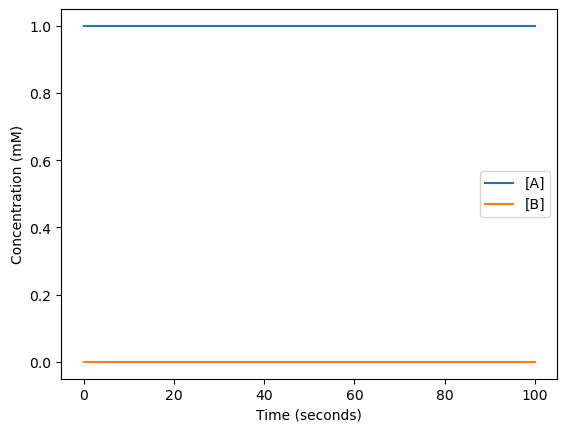

In [14]:
t = np.arange(len(outputA.vector)) * outputA.dt
plt.plot(t, outputA.vector, label='[A]')
plt.plot(t, outputB.vector, label='[B]')
plt.xlabel('Time (seconds)')
plt.ylabel('Concentration (mM)')
plt.legend()

## Perturb the system and continue simulation

It appears that there is hardly any change in $[A]$ and $[B]$. Now we will manipulate the system by swapping A and B. First we will convert 90% of A into B. So $[B]$ will increase by $0.9 \times [A]$, and the $[A]$ will become $0.1 \times [A]$.

*Note that we did not call `reinit()` here! This is because we want to continue the simulation from where it ended.*

In [15]:
# move most molecules over to b
b.conc = b.conc + a.conc * 0.9
a.conc = a.conc * 0.1
moose.start( 100.0 ) # Run the model for 100 seconds.


Now we can plot the accumulated results again:

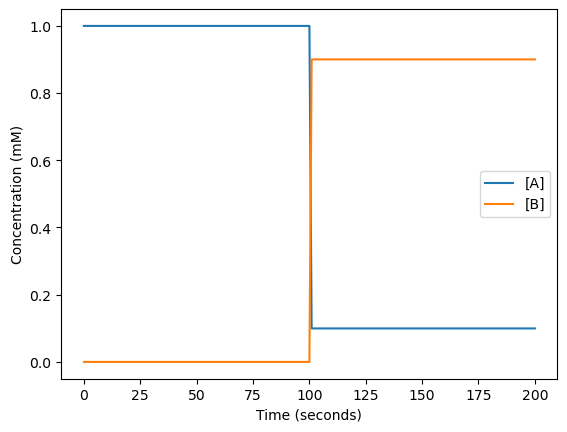

In [16]:
t = np.arange(len(outputA.vector)) * outputA.dt
plt.plot(t, outputA.vector, label='[A]')
plt.plot(t, outputB.vector, label='[B]')
plt.xlabel('Time (seconds)')
plt.ylabel('Concentration (mM)')
plt.legend()

These lines look a bit too straight. That's because you cannot have reactions with fractional molecules, so the system gets stuck into the state it is. To avoid the stuck state, we need to add an additional reaction that converts $A$ to $B$.

Since the solver has already been setup, it is simpler to delete the model and start fresh/

## Same model with and extra reaction $A \rightarrow B$

In [17]:
if moose.exists(cpath):
    moose.delete(cpath)
moose.Neutral(cpath)
    
model = moose.Neutral(f'{cpath}/model')
data = moose.Neutral(f'{cpath}/data')

# Setup chemical compartment for the reaction

comp = moose.CubeMesh(f'{model.path}/comp')   # Chemical compartment
comp.volume = 1e-21 # m^3

# Get a handle to the mesh created automatically by the compartment
mesh = moose.element(f'{comp.path}/mesh' ) 

# Create molecules and reactions

# Pools are the molecule-pools for substrates, products, and enzymes
a = moose.Pool(f'{comp.path}/a')
b = moose.Pool(f'{comp.path}/b')
c = moose.Pool(f'{comp.path}/c')

# Create the enzymatic reaction objects
enz1 = moose.Enz(f'{comp.path}/b/enz1')
enz2 = moose.Enz(f'{comp.path}/c/enz2')

# Create molecule pools representing enzyme-substrate complex
cplx1 = moose.Pool(f'{comp.path}/b/enz1/cplx')
cplx2 = moose.Pool(f'{comp.path}/c/enz2/cplx')

### The additional reaction is added here

In [18]:
reac = moose.Reac(f'{comp.path}/reac' )


Again we connect up all the model components

In [19]:
# Connect them up for reactions ...

# Connect enzymatic reaction enz1 to its molecule pools
moose.connect(enz1, 'sub', a, 'reac')  # a is the substrate molecule pool for enz1 (b)
moose.connect(enz1, 'prd', b, 'reac')  # b is the product molecule pool for enz1 
moose.connect(enz1, 'enz', b, 'reac')  # b is also the enzyme molecule pool for enz1
moose.connect(enz1, 'cplx', cplx1, 'reac')   # cplx1 is the enzyme-substrate complex pool for enz1

# Connect enzymatic reaction enz2 to its molecule pools
moose.connect(enz2, 'sub', b, 'reac')   # b is the substrate molecule pool for enz2 (c)
moose.connect(enz2, 'prd', a, 'reac')   # a is the product molecule pool for enz2 
moose.connect(enz2, 'enz', c, 'reac')   # c is the enzyme molecule pool for enz2
moose.connect(enz2, 'cplx', cplx2, 'reac')  # cplx2 is the enzyme-substrate complex pool for enz2

<moose.SingleMsg id=5 dataIndex=18 path=/Msgs[0]/singleMsg[18]>

### And connect the Reac object

In [20]:
moose.connect(reac, 'sub', a, 'reac' )
moose.connect(reac, 'prd', b, 'reac' )

<moose.SingleMsg id=5 dataIndex=20 path=/Msgs[0]/singleMsg[20]>

### Setup data recording
This is same as before

In [21]:
# Create the output tables
outputA = moose.Table2(f'/{data.path}/concA')
outputB = moose.Table2(f'{data.path}/concB')

# connect up the tables
moose.connect(outputA, 'requestOut', a, 'getConc')
moose.connect(outputB, 'requestOut', b, 'getConc')

<moose.SingleMsg id=5 dataIndex=22 path=/Msgs[0]/singleMsg[22]>

### Setup solver 
This is also the same as before

In [22]:
stoich = moose.Stoich(f'{comp.path}/stoich')
stoich.compartment = moose.element(f'{comp.path}')
solver = moose.Gsolve(f'{comp.path}/gsolve')
stoich.ksolve = solver
stoich.reacSystemPath = f'{comp.path}/##'

In [23]:
# Assign parameters
a.concInit = 1
b.concInit = 0
c.concInit = 0.01
enz1.kcat = 0.4
enz1.Km = 4
enz2.kcat = 0.6
enz2.Km = 0.01

# The forward and backward rate constants for the Reac element
reac.Kf = 0.001
reac.Kb = 0.01


### And run the simulation

Now we put together all the run steps (reinit, run, swap a and b, swap a and b again) and plot the data.

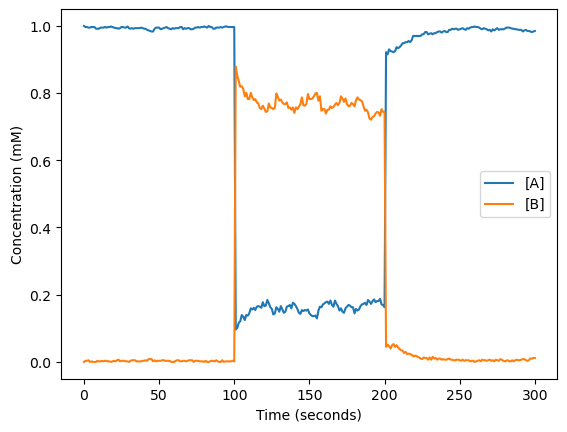

In [24]:
moose.reinit()
moose.start(100.0)

# move most molecules over to b
b.conc = b.conc + a.conc * 0.9
a.conc = a.conc * 0.1
moose.start( 100.0 ) # Run the model for 100 seconds.

# move most molecules back to a
a.conc = a.conc + b.conc * 0.99
b.conc = b.conc * 0.01
moose.start(100.0) # Run the model for 100 seconds.

# Plot the concentratiosn of A and B
t = np.arange(len(outputA.vector)) * outputA.dt
plt.plot(t, outputA.vector, label='[A]')
plt.plot(t, outputB.vector, label='[B]')
plt.xlabel('Time (seconds)')
plt.ylabel('Concentration (mM)')
plt.legend()

These jagged lines reflect the fact that when the numbers are small, the system does not follow the smooth changes suggested by the mass-action law. Instead, the number of product and substrate molecules can go up and down in discrete fashion.

# Exercises

1. Change the initial concentration of B (`b.concInit`) to 0.1 mM in the "Assign parameters" step, and rerun the rest of this notebook. What do you observe?
2. Change the initial concentration of C to 0.4 mM. How does the system behave now?
3. Now take a range of values of initial concentration of A and note down what you observe.
4. The number of particles in each `Pool` is represented by the field `n`. The corresponding `dest` field is `getN`. Instead of connecting to `getConc`, connect the `requestOut` of the tables to `getN` of the corresponding pool. What do you observe. Try re-plotting only a small duration of a single `Pool` to zoom into the numbers (or use `plt.xlim(xmin, xmax)` and `plt.ylim(ymin, ymax)` to define the limits of the plot window).